In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import math
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('/content/btc_1h.csv')

In [ ]:
df.head(1)

datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199

In [ ]:
df.tail(1)

datetime      open      high       low    close      volume
35663  2022-01-31 05:30:00  37881.75  37951.07  36828.32  36829.3  2907.71096

In [ ]:
df['High']

Date
2020-01-02     75.150002
2020-01-03     75.144997
2020-01-06     74.989998
2020-01-07     75.224998
2020-01-08     76.110001
                 ...    
2024-01-02    188.440002
2024-01-03    185.880005
2024-01-04    183.089996
2024-01-05    182.759995
2024-01-08    185.600006
Name: High, Length: 1011, dtype: float64

In [ ]:
def Supertrend(df, atr_period, multiplier):

    high = df['High']
    low = df['Low']
    close = df['Close']

    # calculate ATR
    price_diffs = [high - low,
                   high - close.shift(),
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean()
    # df['atr'] = df['tr'].rolling(atr_period).mean()

    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)

    # initialize Supertrend column to True
    supertrend = [True] * len(df)

    for i in range(1, len(df.index)):
        curr, prev = i, i-1

        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]

            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan

    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)


atr_period = 10
atr_multiplier = 3.0

stock_list = ['AAPL']
for symbol in stock_list:
    df = yf.download(symbol, start='2020-01-01')
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    df = df.join(supertrend)
df.tail(15)

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-12-15  197.529999  198.399994  197.000000  197.570007  197.570007   
2023-12-18  196.089996  196.630005  194.389999  195.889999  195.889999   
2023-12-19  196.160004  196.949997  195.889999  196.940002  196.940002   
2023-12-20  196.899994  197.679993  194.830002  194.830002  194.830002   
2023-12-21  196.100006  197.080002  193.500000  194.679993  194.679993   
2023-12-22  195.179993  195.410004  192.970001  193.600006  193.600006   
2023-12-26  193.610001  193.889999  192.830002  193.050003  193.050003   
2023-12-27  192.490005  193.500000  191.089996  193.149994  193.149994   
2023-12-28  194.139999  194.660004  193.169998  193.580002  193.580002   
2023-12-29  193.899994  194.399994  191.729996  192.529999  192.529999   
2024-01-02  187.149994  188.440002  183.889999  185.639999  185.639999   
2024-01-03  184.220001  185.880005  183.429993  184.250000  184.250000   
2024-01-04  182.149994  183.089996  180.880005  181.910004  181.910004   
2024-01-05  181.990005  182.759995  180.169998  181.179993  181.179993   
2024-01-08  182.089996  185.600006  181.500000  185.559998  185.559998   

               Volume  Supertrend  Final Lowerband  Final Upperband  
Date                                                                 
2023-12-15  128256700        True       189.159708              NaN  
2023-12-18   55751900        True       189.159708              NaN  
2023-12-19   40714100        True       189.159708              NaN  
2023-12-20   52242800        True       189.159708              NaN  
2023-12-21   46482500        True       189.159708              NaN  
2023-12-22   37122800        True       189.159708              NaN  
2023-12-26   28919300        True       189.159708              NaN  
2023-12-27   48087700        True       189.159708              NaN  
2023-12-28   34049900        True       189.159708              NaN  
2023-12-29   42628800        True       189.159708              NaN  
2024-01-02   82488700       False              NaN       195.476792  
2024-01-03   58414500       False              NaN       193.770615  
2024-01-04   71983600       False              NaN       191.200053  
2024-01-05   62303300       False              NaN       190.535543  
2024-01-08   59087900       False              NaN       190.535543

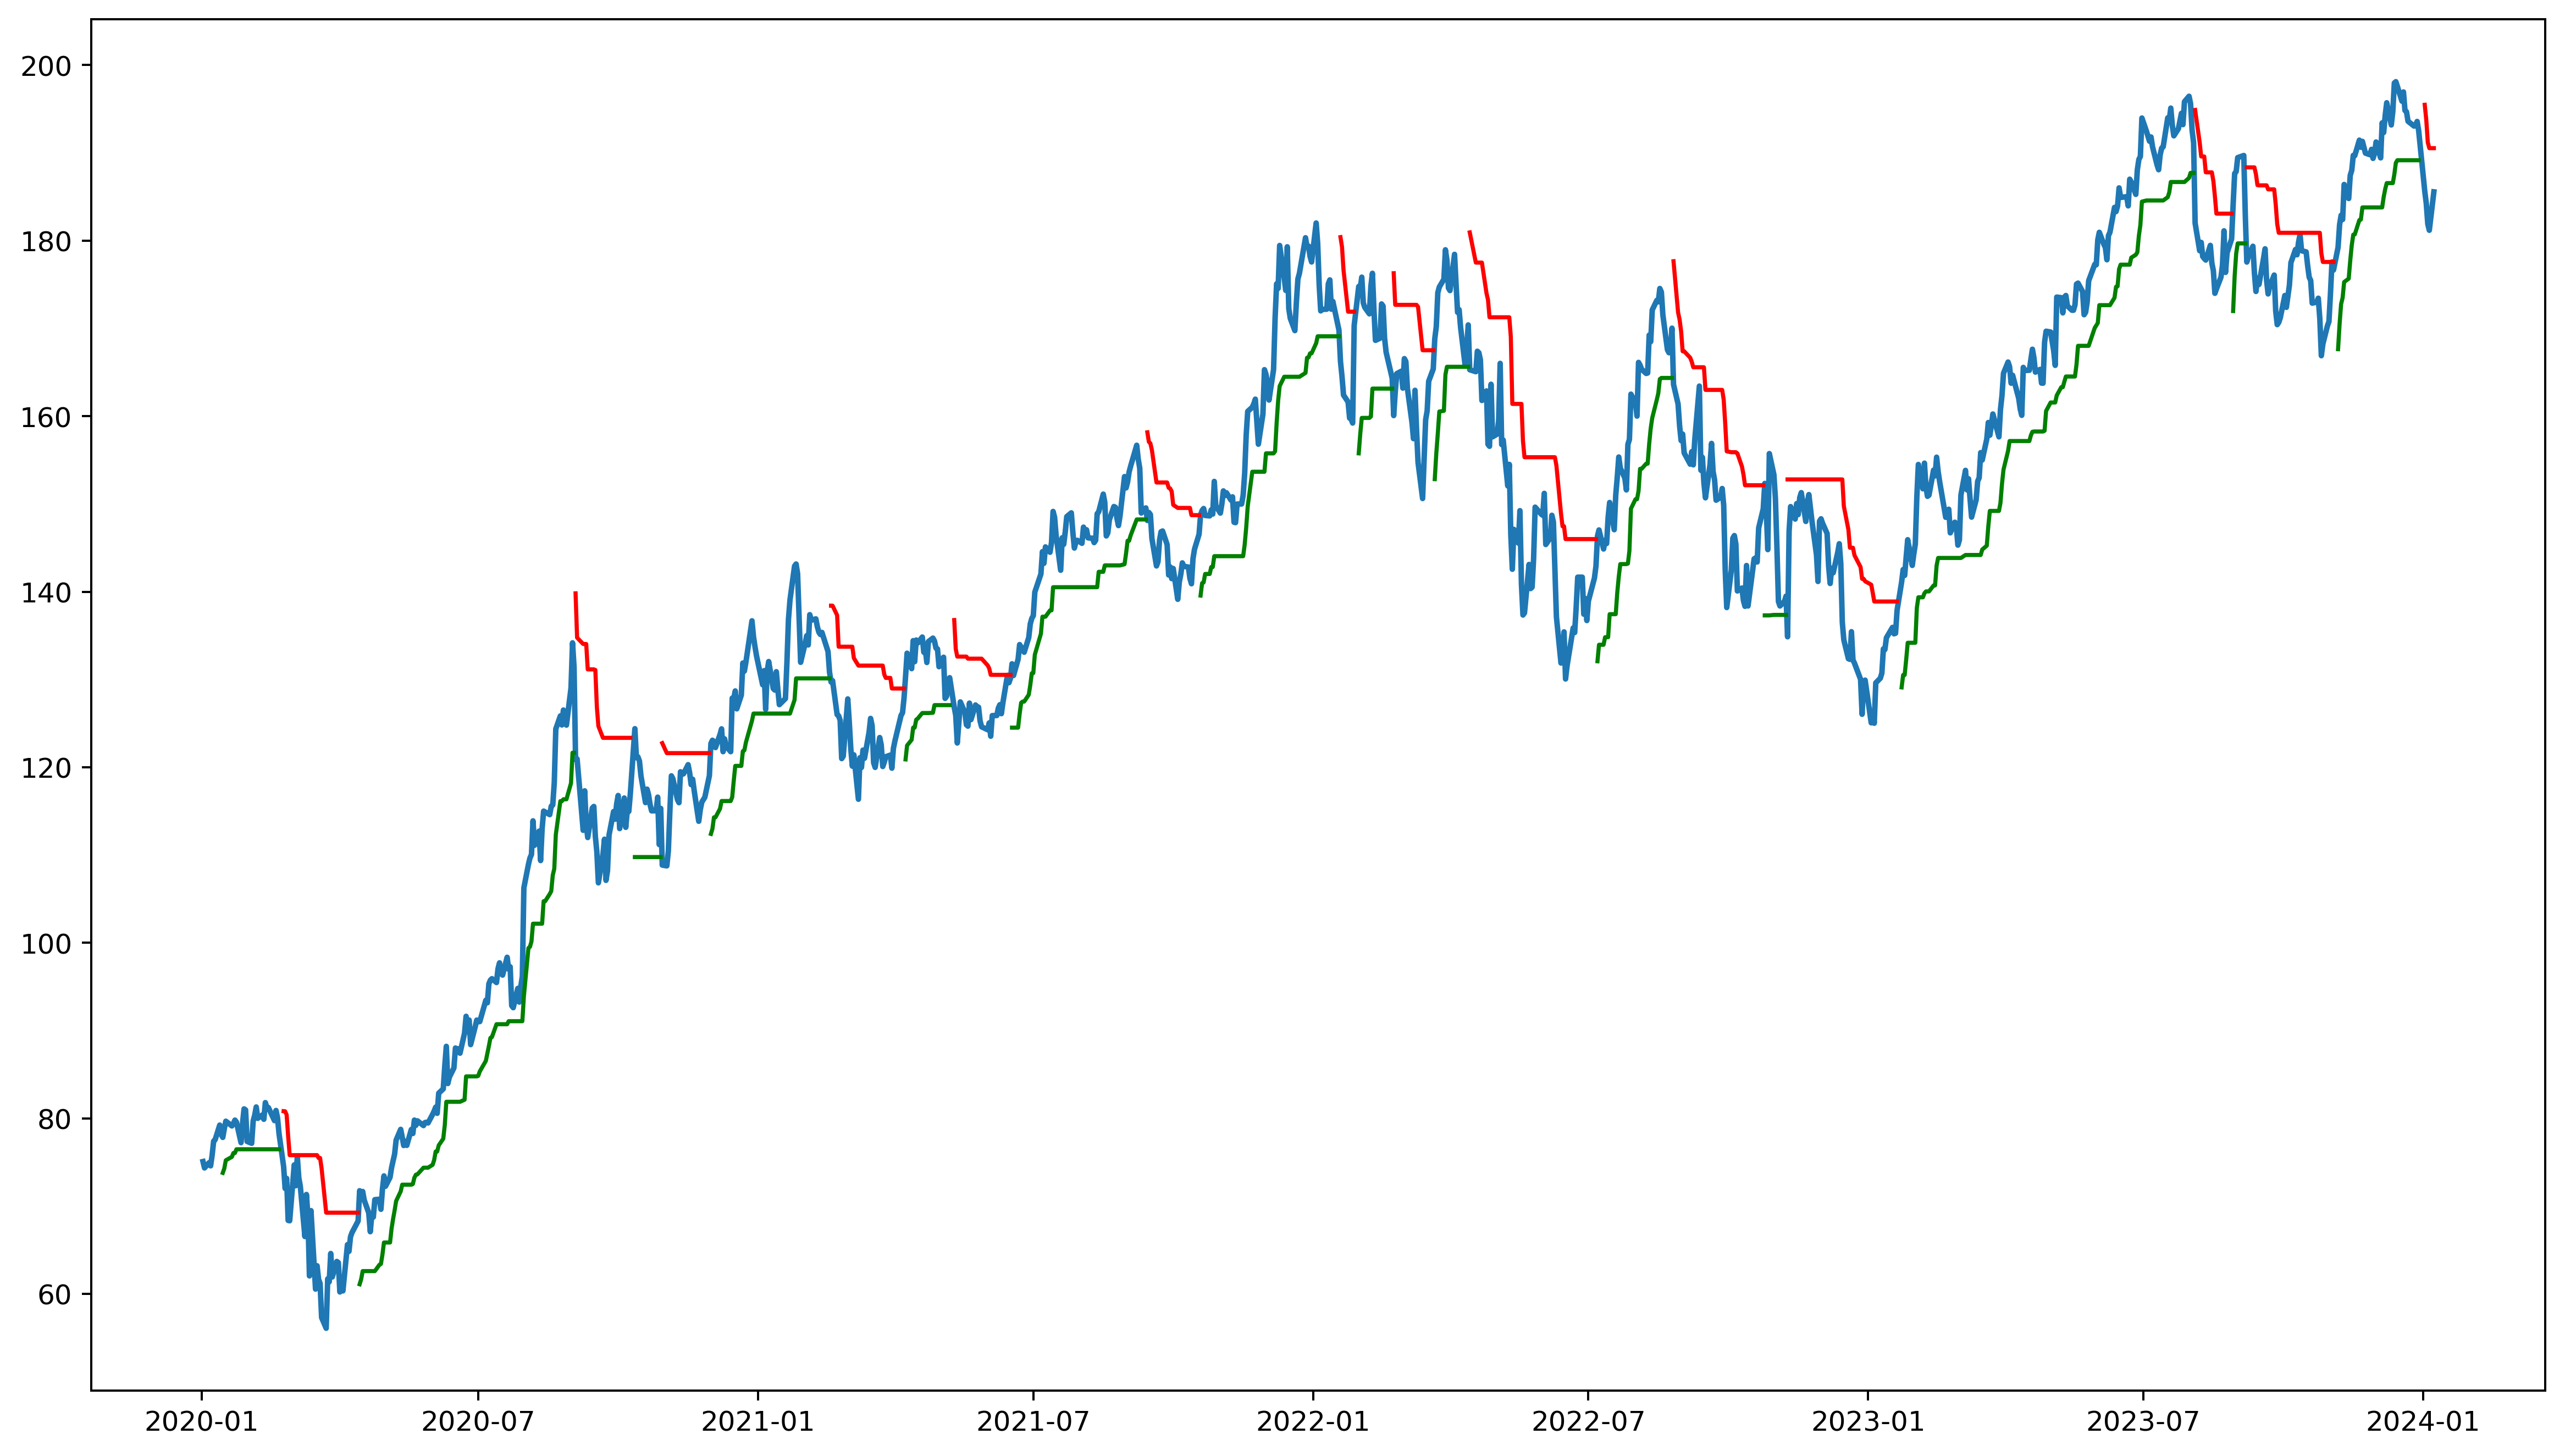

In [ ]:
# visualization
plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], linewidth = 2, label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()

In [ ]:
# backtesting

def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']

    # initial condition
    in_position = False
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []

    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
#             print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        # if in position & price is not on uptrend -> sell
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
#             print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
    # if still in position -> sell all share
    if in_position:
        equity += share * close[i] - commission

    earning = equity - investment
    roi = round(earning/investment*100,2)
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, roi
entry, exit, roi = backtest_supertrend(df, 100000)

Earning from investing $100k is $108658.25 (ROI = 108.66%)


In [ ]:
if entry:
    entry_index = entry[0][0]
    entry_time = df.index[entry_index]
    print(f'Time of Investing: {entry_time.strftime("%Y/%m/%d %H:%M:%S")}')

if exit:
    exit_index = exit[0][0]
    exit_time = df.index[exit_index]
    print(f'Time of Exiting: {exit_time.strftime("%Y/%m/%d %H:%M:%S")}')

Time of Investing: 2020/01/06 00:00:00
Time of Exiting: 2020/02/24 00:00:00


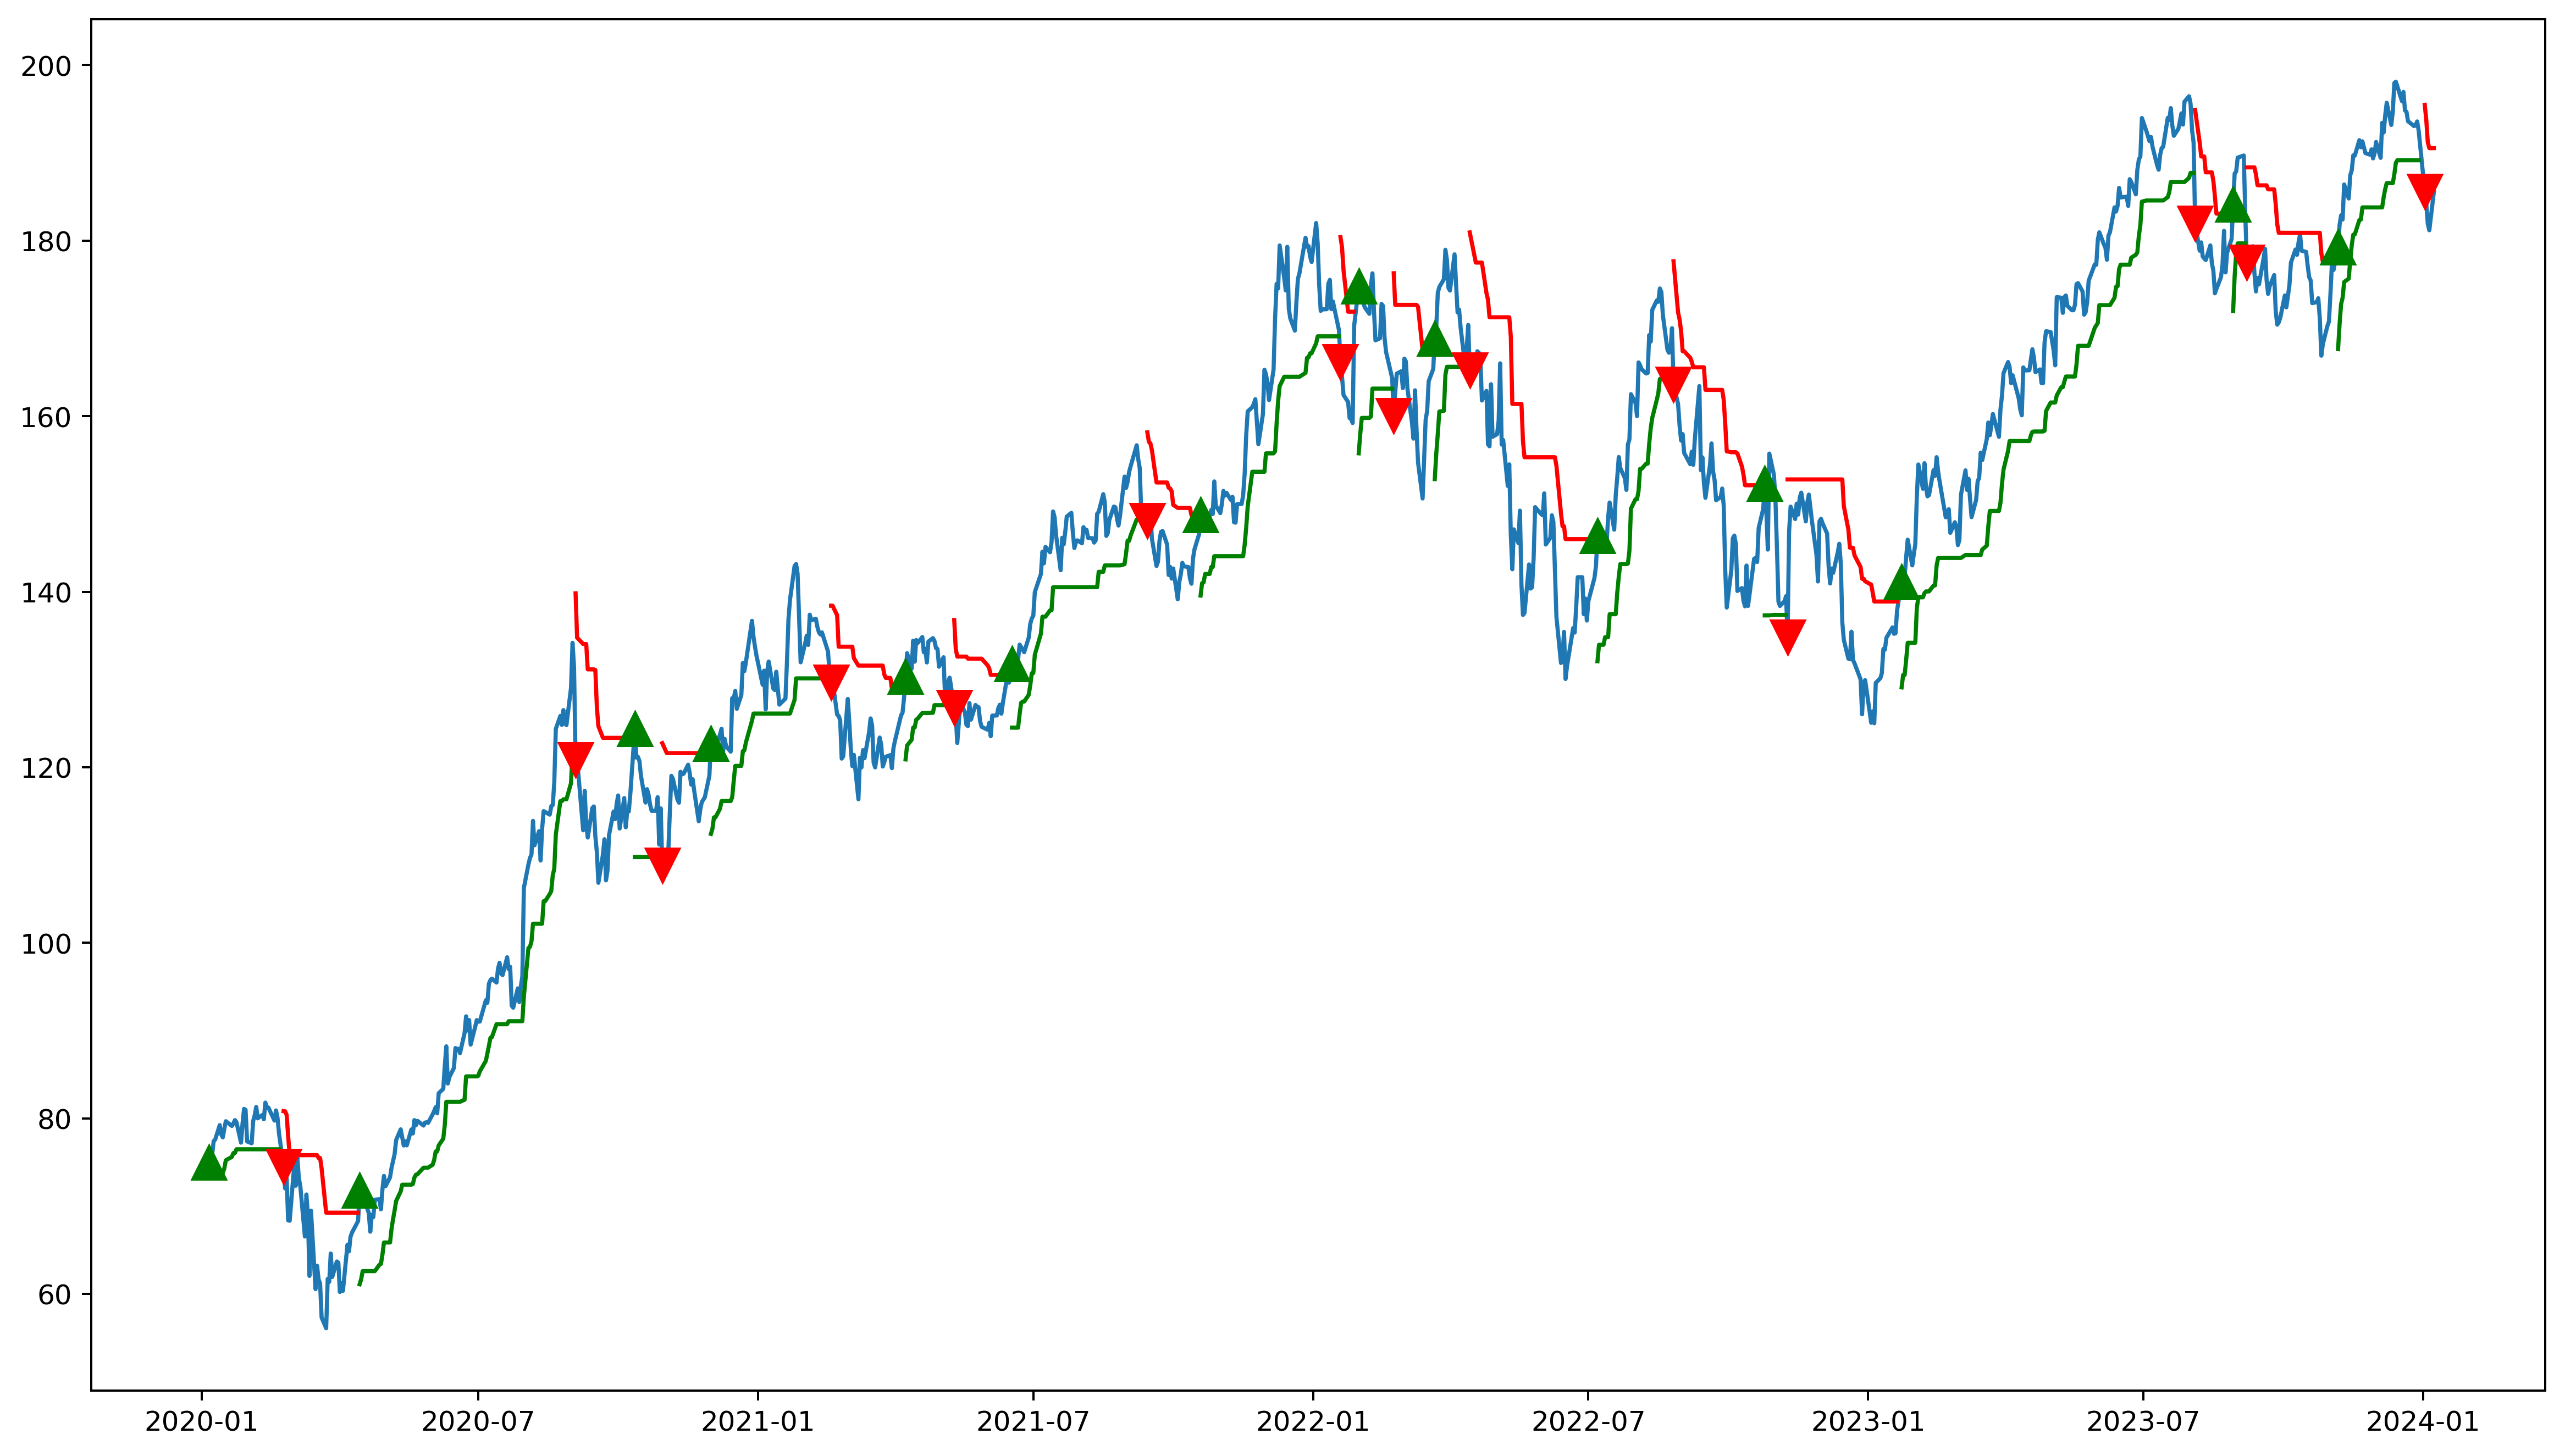

In [ ]:
# visualization (for backtest)

plt.figure(figsize=(16,9),dpi=360)
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'],'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
for e in entry:
    plt.plot(df.index[e[0]], e[1], marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'Entry')
for e in exit:
    plt.plot(df.index[e[0]], e[1], marker = 'v', color = 'red', markersize = 12, linewidth = 0, label = 'Exit')
plt.show()